# Heat and FW Fluxes

The simulations run from '2150-01-01' to '2164-12-31'

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import cftime

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client()
client

<Client: 'tcp://127.0.0.1:38041' processes=4 threads=16, memory=44.92 GiB>

In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# database for perturbations:
easterlies_session = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')
# 10% increase in easterly wind speed: WIND+
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
# 10% decrease in easterly wind speed: WIND-
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'
# 10% increase in easterly wind speed EXCEPT in DSW forming regions : WIND+_{NoDSW}
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10_noDSW'
# 10% increase in ZONAL easterly wind speed: WIND+_{zonal}
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10_zonal'
# 10% increase in MERIDIONAL easterly wind speed: WIND+_{merid}
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10_meridional'


# plot anomalies for last 5 years of simulation:
start_time='2150-01-01'
end_time='2164-12-31'
last_five=slice(cftime.datetime(2160, 1, 1, 0, 0, 0, 0, calendar='noleap', has_year_zero=True),cftime.datetime(2164, 12, 31, 0, 0, 0, 0, calendar='noleap', has_year_zero=True))

lat_slice  = slice(-80,-60)

In [4]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

In [5]:
shelf_mask = np.squeeze(ht.values)*0
shelf_mask  = np.where(ht.values<1000,1, np.nan)

fontsize=16

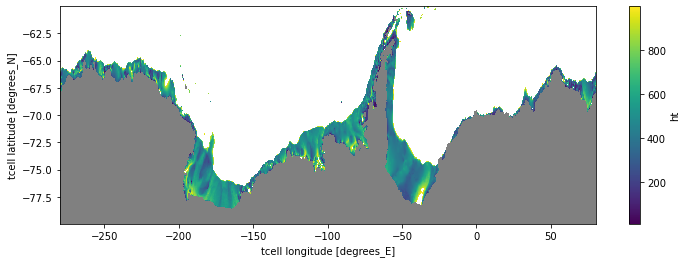

In [6]:
plt.figure(figsize=(12,4))
(ht*shelf_mask).plot()
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='gray')

In [8]:
dbx = cc.explore.DatabaseExplorer(session=master_session)
dbx

DatabaseExplorer(children=(HTML(value='<style>.header p{ line-height: 1.4; margin-bottom: 10px }</style>\n    …

## Plot average over last 5 years:
Note that this is lazy time averaging (i.e. does not account for number of days in each month). This should be fixed for final paper figures.

* The relevant heat flux terms are:

`heat flux = (swflx + lw_heat + sens_heat + evap_heat + fprec_melt_heat + sfc_hflux_pme +sfc_hflux_from_runoff) + frazil_3d_int_z [calving=0?]`

where () terms are in net_sfc_heating.

* FW flux is given by:

`fwflux = (lprec + fprec + river + evap + melt) - (sfc_salt_flux_ice + sfc_salt_flux_restore)`

 -- for ice contribution we only need `(melt - sfc_salt_flux_ice)`

Here we load each component and then sum (and load) for each experiment.

In [11]:
swflx = cc.querying.getvar(control, 'swflx', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
lw_heat = cc.querying.getvar(control, 'lw_heat', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
sens_heat = cc.querying.getvar(control, 'sens_heat', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
evap_heat = cc.querying.getvar(control, 'evap_heat', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
fprec_melt_heat = cc.querying.getvar(control, 'fprec_melt_heat', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
sfc_hflux_pme = cc.querying.getvar(control, 'sfc_hflux_pme', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
sfc_hflux_from_runoff = cc.querying.getvar(control, 'sfc_hflux_from_runoff', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
frazil_3d_int_z = cc.querying.getvar(control, 'frazil_3d_int_z', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)

## these are all the components. Still need to add then pull apart. Divide into summer and winter.
net_sfc_heating_con_summer = (swflx + lw_heat + sens_heat + evap_heat + fprec_melt_heat + sfc_hflux_pme + sfc_hflux_from_runoff + frazil_3d_int_z).sel(yt_ocean=lat_slice).sel(time=last_five).groupby('time.month').mean('time').sel(month=slice(1,6)).mean('month').load()
net_sfc_heating_con_winter = (swflx + lw_heat + sens_heat + evap_heat + fprec_melt_heat + sfc_hflux_pme + sfc_hflux_from_runoff + frazil_3d_int_z).sel(yt_ocean=lat_slice).sel(time=last_five).groupby('time.month').mean('time').sel(month=slice(7,12)).mean('month').load()
net_sfc_heating_con_ts = ((swflx + lw_heat + sens_heat + evap_heat + fprec_melt_heat + sfc_hflux_pme + sfc_hflux_from_runoff + frazil_3d_int_z).sel(yt_ocean=lat_slice)*shelf_mask).mean(dim={'xt_ocean','yt_ocean'}).load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, 

In [7]:
lprec = cc.querying.getvar(control, 'lprec', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
fprec = cc.querying.getvar(control, 'fprec', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
evap = cc.querying.getvar(control, 'evap', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
river = cc.querying.getvar(control, 'river', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
melt = cc.querying.getvar(control, 'melt', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
sfc_salt_flux_ice = cc.querying.getvar(control, 'sfc_salt_flux_ice', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
sfc_salt_flux_restore = cc.querying.getvar(control, 'sfc_salt_flux_restore', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)

net_sfc_fw_flux_con_summer = (lprec + fprec + river + evap +melt - sfc_salt_flux_ice - sfc_salt_flux_restore).sel(yt_ocean=lat_slice).sel(time=last_five).groupby('time.month').mean('time').sel(month=slice(1,6)).mean('month').load()
net_sfc_fw_flux_con_winter = (lprec + fprec + river + evap +melt - sfc_salt_flux_ice - sfc_salt_flux_restore).sel(yt_ocean=lat_slice).sel(time=last_five).groupby('time.month').mean('time').sel(month=slice(7,12)).mean('month').load()
net_ice_fw_flux_con_summer = (melt - sfc_salt_flux_ice).sel(yt_ocean=lat_slice).sel(time=last_five).groupby('time.month').mean('time').sel(month=slice(1,6)).mean('month').load()
net_ice_fw_flux_con_winter = (melt - sfc_salt_flux_ice).sel(yt_ocean=lat_slice).sel(time=last_five).groupby('time.month').mean('time').sel(month=slice(7,12)).mean('month').load()
net_sfc_fw_flux_con_ts = ((lprec + fprec + river + evap +melt - sfc_salt_flux_ice - sfc_salt_flux_restore).sel(yt_ocean=lat_slice)*shelf_mask).mean(dim={'xt_ocean','yt_ocean'}).load()
net_ice_fw_flux_con_ts = ((melt - sfc_salt_flux_ice).sel(yt_ocean=lat_slice)*shelf_mask).mean(dim={'xt_ocean','yt_ocean'}).load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, 

In [12]:
swflx = cc.querying.getvar(easterlies_up, 'swflx', easterlies_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
lw_heat = cc.querying.getvar(easterlies_up, 'lw_heat',easterlies_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
sens_heat = cc.querying.getvar(easterlies_up, 'sens_heat', easterlies_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
evap_heat = cc.querying.getvar(easterlies_up, 'evap_heat', easterlies_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
fprec_melt_heat = cc.querying.getvar(easterlies_up, 'fprec_melt_heat', easterlies_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
sfc_hflux_pme = cc.querying.getvar(easterlies_up, 'sfc_hflux_pme', easterlies_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
sfc_hflux_from_runoff = cc.querying.getvar(easterlies_up, 'sfc_hflux_from_runoff', easterlies_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
frazil_3d_int_z = cc.querying.getvar(easterlies_up, 'frazil_3d_int_z', easterlies_session, frequency='1 monthly',start_time=start_time, end_time=end_time)

## these are all the components. Still need to add then pull apart.
net_sfc_heating_up_summer = (swflx + lw_heat + sens_heat + evap_heat + fprec_melt_heat + sfc_hflux_pme + sfc_hflux_from_runoff + frazil_3d_int_z).sel(yt_ocean=lat_slice).sel(time=last_five).groupby('time.month').mean('time').sel(month=slice(1,6)).mean('month').load()
net_sfc_heating_up_winter = (swflx + lw_heat + sens_heat + evap_heat + fprec_melt_heat + sfc_hflux_pme + sfc_hflux_from_runoff + frazil_3d_int_z).sel(yt_ocean=lat_slice).sel(time=last_five).groupby('time.month').mean('time').sel(month=slice(7,12)).mean('month').load()
net_sfc_heating_up_ts = ((swflx + lw_heat + sens_heat + evap_heat + fprec_melt_heat + sfc_hflux_pme + sfc_hflux_from_runoff + frazil_3d_int_z).sel(yt_ocean=lat_slice)*shelf_mask).mean(dim={'xt_ocean','yt_ocean'}).load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, 

In [8]:
lprec = cc.querying.getvar(easterlies_up, 'lprec', easterlies_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
fprec = cc.querying.getvar(easterlies_up, 'fprec', easterlies_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
evap = cc.querying.getvar(easterlies_up, 'evap', easterlies_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
river = cc.querying.getvar(easterlies_up, 'river', easterlies_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
melt = cc.querying.getvar(easterlies_up, 'melt', easterlies_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
sfc_salt_flux_ice = cc.querying.getvar(easterlies_up, 'sfc_salt_flux_ice', easterlies_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
sfc_salt_flux_restore = cc.querying.getvar(easterlies_up, 'sfc_salt_flux_restore', easterlies_session, frequency='1 monthly',start_time=start_time, end_time=end_time)

net_sfc_fw_flux_up_summer = (lprec + fprec + river + evap + melt - sfc_salt_flux_ice - sfc_salt_flux_restore).sel(yt_ocean=lat_slice).sel(time=last_five).groupby('time.month').mean('time').sel(month=slice(1,6)).mean('month').load()
net_sfc_fw_flux_up_winter = (lprec + fprec + river + evap + melt - sfc_salt_flux_ice - sfc_salt_flux_restore).sel(yt_ocean=lat_slice).sel(time=last_five).groupby('time.month').mean('time').sel(month=slice(7,12)).mean('month').load()
net_ice_fw_flux_up_summer = (melt - sfc_salt_flux_ice).sel(yt_ocean=lat_slice).sel(time=last_five).groupby('time.month').mean('time').sel(month=slice(1,6)).mean('month').load()
net_ice_fw_flux_up_winter = (melt - sfc_salt_flux_ice).sel(yt_ocean=lat_slice).sel(time=last_five).groupby('time.month').mean('time').sel(month=slice(7,12)).mean('month').load()
net_sfc_fw_flux_up_ts = ((lprec + fprec + river + evap + melt - sfc_salt_flux_ice - sfc_salt_flux_restore).sel(yt_ocean=lat_slice)*shelf_mask).mean(dim={'xt_ocean','yt_ocean'}).load()
net_ice_fw_flux_up_ts = ((melt - sfc_salt_flux_ice).sel(yt_ocean=lat_slice)*shelf_mask).mean(dim={'xt_ocean','yt_ocean'}).load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, 

In [13]:
swflx = cc.querying.getvar(easterlies_down, 'swflx', easterlies_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
lw_heat = cc.querying.getvar(easterlies_down, 'lw_heat',easterlies_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
sens_heat = cc.querying.getvar(easterlies_down, 'sens_heat', easterlies_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
evap_heat = cc.querying.getvar(easterlies_down, 'evap_heat', easterlies_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
fprec_melt_heat = cc.querying.getvar(easterlies_down, 'fprec_melt_heat', easterlies_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
sfc_hflux_pme = cc.querying.getvar(easterlies_down, 'sfc_hflux_pme', easterlies_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
sfc_hflux_from_runoff = cc.querying.getvar(easterlies_down, 'sfc_hflux_from_runoff', easterlies_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
frazil_3d_int_z = cc.querying.getvar(easterlies_down, 'frazil_3d_int_z', easterlies_session, frequency='1 monthly',start_time=start_time, end_time=end_time)

## these are all the components. Still need to add then pull apart.
net_sfc_heating_down_summer = (swflx + lw_heat + sens_heat + evap_heat + fprec_melt_heat + sfc_hflux_pme + sfc_hflux_from_runoff + frazil_3d_int_z).sel(yt_ocean=lat_slice).sel(time=last_five).groupby('time.month').mean('time').sel(month=slice(1,6)).mean('month').load()
net_sfc_heating_down_winter = (swflx + lw_heat + sens_heat + evap_heat + fprec_melt_heat + sfc_hflux_pme + sfc_hflux_from_runoff + frazil_3d_int_z).sel(yt_ocean=lat_slice).sel(time=last_five).groupby('time.month').mean('time').sel(month=slice(7,12)).mean('month').load()
net_sfc_heating_down_ts = ((swflx + lw_heat + sens_heat + evap_heat + fprec_melt_heat + sfc_hflux_pme + sfc_hflux_from_runoff + frazil_3d_int_z).sel(yt_ocean=lat_slice)*shelf_mask).mean(dim={'xt_ocean','yt_ocean'}).load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, 

In [9]:
lprec = cc.querying.getvar(easterlies_down, 'lprec', easterlies_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
fprec = cc.querying.getvar(easterlies_down, 'fprec', easterlies_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
evap = cc.querying.getvar(easterlies_down, 'evap', easterlies_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
river = cc.querying.getvar(easterlies_down, 'river', easterlies_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
melt = cc.querying.getvar(easterlies_down, 'melt', easterlies_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
sfc_salt_flux_ice = cc.querying.getvar(easterlies_down, 'sfc_salt_flux_ice', easterlies_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
sfc_salt_flux_restore = cc.querying.getvar(easterlies_down, 'sfc_salt_flux_restore', easterlies_session, frequency='1 monthly',start_time=start_time, end_time=end_time)

net_sfc_fw_flux_down_summer = (lprec + fprec + river + evap + melt - sfc_salt_flux_ice - sfc_salt_flux_restore).sel(yt_ocean=lat_slice).sel(time=last_five).groupby('time.month').mean('time').sel(month=slice(1,6)).mean('month').load()
net_sfc_fw_flux_down_winter = (lprec + fprec + river + evap + melt - sfc_salt_flux_ice - sfc_salt_flux_restore).sel(yt_ocean=lat_slice).sel(time=last_five).groupby('time.month').mean('time').sel(month=slice(7,12)).mean('month').load()
net_ice_fw_flux_down_summer = (melt - sfc_salt_flux_ice).sel(yt_ocean=lat_slice).sel(time=last_five).groupby('time.month').mean('time').sel(month=slice(1,6)).mean('month').load()
net_ice_fw_flux_down_winter = (melt - sfc_salt_flux_ice).sel(yt_ocean=lat_slice).sel(time=last_five).groupby('time.month').mean('time').sel(month=slice(7,12)).mean('month').load()
net_sfc_fw_flux_down_ts = ((lprec + fprec + river + evap + melt - sfc_salt_flux_ice - sfc_salt_flux_restore).sel(yt_ocean=lat_slice)*shelf_mask).mean(dim={'xt_ocean','yt_ocean'}).load()
net_ice_fw_flux_down_ts = ((melt - sfc_salt_flux_ice).sel(yt_ocean=lat_slice)*shelf_mask).mean(dim={'xt_ocean','yt_ocean'}).load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, 

## First, plot timeseries of anomalies, averaged over the shelf
This plot shows that heat and FW flux anomalies are highly seasonal, equilibrate within a couple of years and are repeatable.

Text(0.5, 1.0, 'Net FW Flux (anomalies from climatology)')

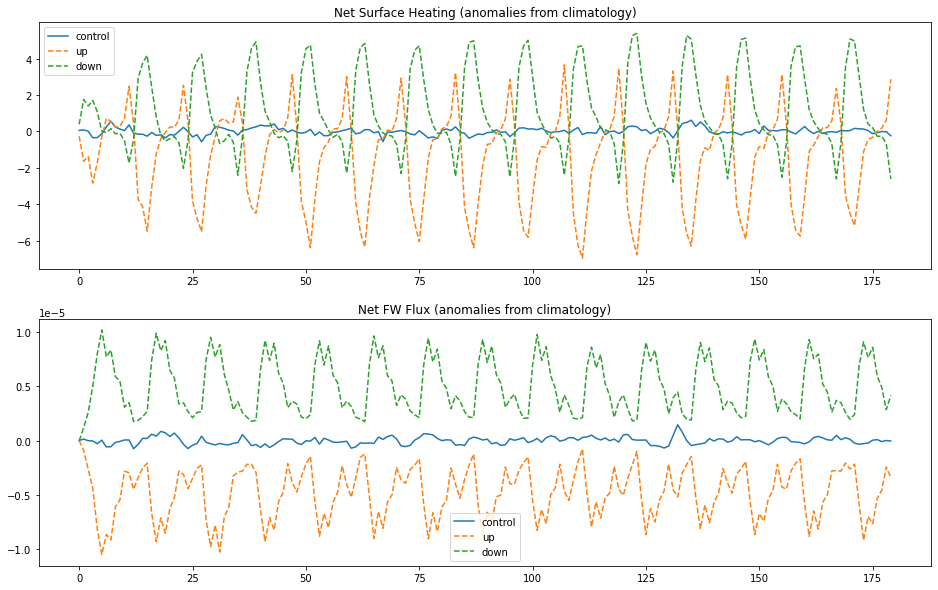

In [14]:
plt.figure(figsize=(16,10))
plt.subplot(211)
climatology = net_sfc_heating_con_ts.groupby('time.month').mean('time')
plt.plot((net_sfc_heating_con_ts.groupby('time.month') - climatology).values[3:],label='control')
plt.plot((net_sfc_heating_up_ts.groupby('time.month') - climatology).values,linestyle='--',label='up')
plt.plot((net_sfc_heating_down_ts.groupby('time.month') - climatology).values,linestyle='--',label='down')
plt.legend()
plt.title('Net Surface Heating (anomalies from climatology)')
plt.subplot(212)
climatology = net_sfc_fw_flux_con_ts.groupby('time.month').mean('time')
plt.plot((net_sfc_fw_flux_con_ts.groupby('time.month') - climatology).values[3:],label='control')
plt.plot((net_sfc_fw_flux_up_ts.groupby('time.month') - climatology).values,linestyle='--',label='up')
plt.plot((net_sfc_fw_flux_down_ts.groupby('time.month') - climatology).values,linestyle='--',label='down')
plt.legend()
plt.title('Net FW Flux (anomalies from climatology)')

## Second, plot annual climatology and anomaly, again averaged over the shelf.
Shows the UP case tends to cool and salinify the shelf, especially over summer-autumn.

In [16]:
plt.figure(figsize=(14,8))
plt.subplot(231)
net_sfc_heating_con_ts.groupby('time.month').mean('time').plot(label='control')
net_sfc_heating_up_ts.groupby('time.month').mean('time').plot(linestyle='--',label='up')
net_sfc_heating_down_ts.groupby('time.month').mean('time').plot(linestyle='--',label='down')
plt.legend()
plt.title('Net Surface Heating (climatology)')
plt.subplot(232)
net_sfc_fw_flux_con_ts.groupby('time.month').mean('time').plot(label='control')
net_sfc_fw_flux_up_ts.groupby('time.month').mean('time').plot(linestyle='--',label='up')
net_sfc_fw_flux_down_ts.groupby('time.month').mean('time').plot(linestyle='--',label='down')
plt.legend()
plt.title('Net FW Flux (climatology)')
plt.subplot(233)
net_ice_fw_flux_con_ts.groupby('time.month').mean('time').plot(label='control')
net_ice_fw_flux_up_ts.groupby('time.month').mean('time').plot(linestyle='--',label='up')
net_ice_fw_flux_down_ts.groupby('time.month').mean('time').plot(linestyle='--',label='down')
plt.legend()
plt.title('Net Ice Flux (climatology)')
plt.subplot(234)
climatology = net_sfc_heating_con_ts.groupby('time.month').mean('time')
(net_sfc_heating_up_ts.groupby('time.month').mean('time')-climatology).plot(linestyle='--',label='up')
(net_sfc_heating_down_ts.groupby('time.month').mean('time')-climatology).plot(linestyle='--',label='down')
plt.axhline(0,color='k',linestyle='--')
plt.legend()
plt.title('Net Surface Heating (anomaly)')
plt.subplot(235)
climatology = net_sfc_fw_flux_con_ts.groupby('time.month').mean('time')
(net_sfc_fw_flux_up_ts.groupby('time.month').mean('time')-climatology).plot(linestyle='--',label='up')
(net_sfc_fw_flux_down_ts.groupby('time.month').mean('time')-climatology).plot(linestyle='--',label='down')
plt.axhline(0,color='k',linestyle='--')
plt.legend()
plt.title('Net FW Flux (anomaly)')
plt.subplot(236)
climatology = net_ice_fw_flux_con_ts.groupby('time.month').mean('time')
(net_ice_fw_flux_up_ts.groupby('time.month').mean('time')-climatology).plot(linestyle='--',label='up')
(net_ice_fw_flux_down_ts.groupby('time.month').mean('time')-climatology).plot(linestyle='--',label='down')
plt.axhline(0,color='k',linestyle='--')
plt.legend()
plt.title('Net Ice Flux (anomaly)')

Text(0.5, 1.0, 'Net Ice Flux (anomaly)')

# Third, look at maps of heat fluxes, summer and winter

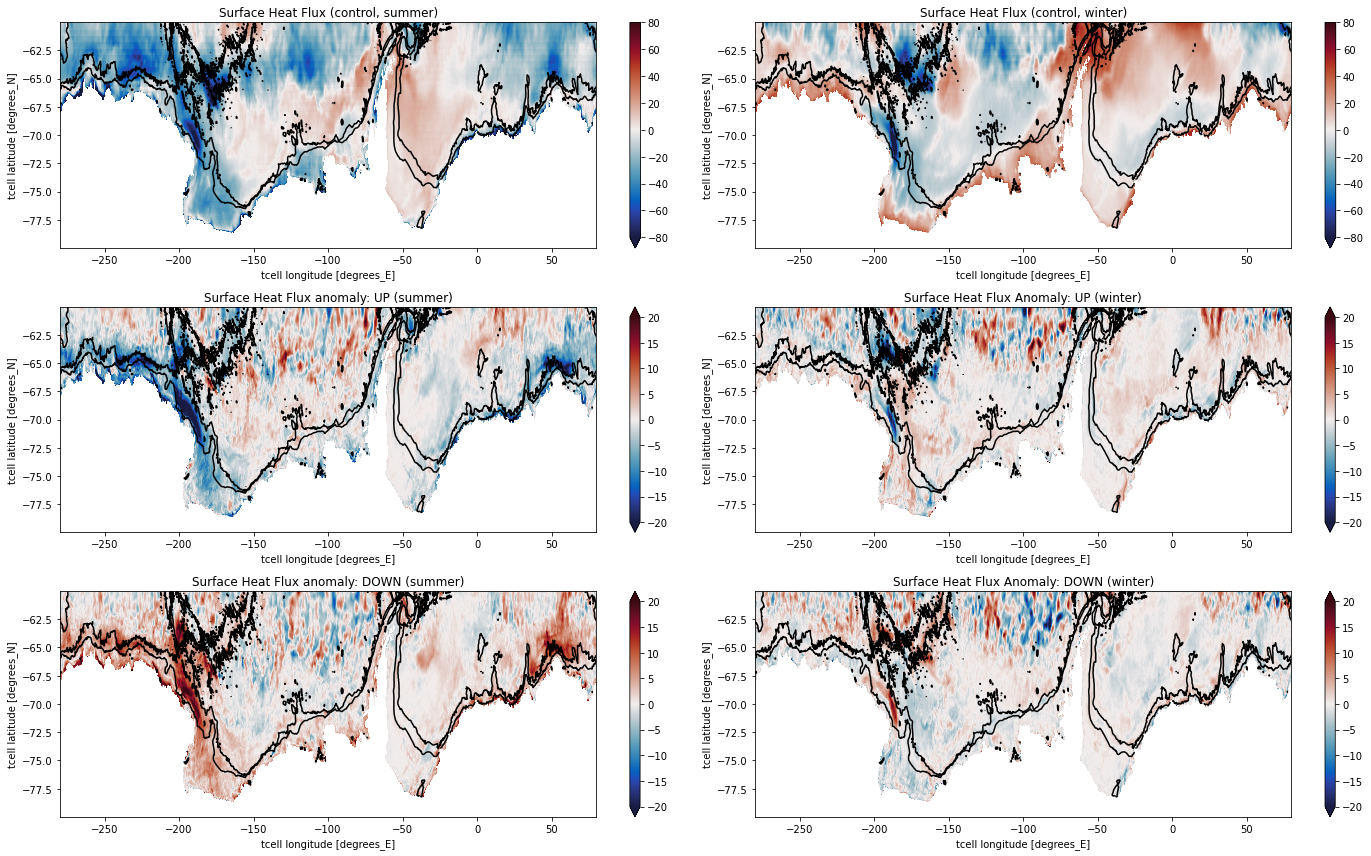

In [56]:
plt.figure(figsize=(20,12))

plt.subplot(3,2,1)
(net_sfc_heating_con_summer).plot(vmin=-80, vmax=80, cmap=cmocean.balance)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=0.2)
plt.title('Surface Heat Flux (control, summer)')

plt.subplot(3,2,2)
(net_sfc_heating_con_winter).plot(vmin=-80, vmax=80, cmap=cmocean.balance)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=0.2)
plt.title('Surface Heat Flux (control, winter)')

plt.subplot(3,2,3)
(net_sfc_heating_up_summer - net_sfc_heating_con_summer).plot(vmin=-20, vmax=20, cmap=cmocean.balance)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=0.2)
plt.title('Surface Heat Flux anomaly: UP (summer)')

plt.subplot(3,2,4)
(net_sfc_heating_up_winter-net_sfc_heating_con_winter).plot(vmin=-20, vmax=20, cmap=cmocean.balance)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=0.2)
plt.title('Surface Heat Flux Anomaly: UP (winter)')

plt.subplot(3,2,5)
(net_sfc_heating_down_summer - net_sfc_heating_con_summer).plot(vmin=-20, vmax=20, cmap=cmocean.balance)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=0.2)
plt.title('Surface Heat Flux anomaly: DOWN (summer)')

plt.subplot(3,2,6)
(net_sfc_heating_down_winter-net_sfc_heating_con_winter).plot(vmin=-20, vmax=20, cmap=cmocean.balance)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=0.2)
plt.title('Surface Heat Flux Anomaly: DOWN (winter)')

plt.tight_layout()

## Fourth, how about maps of salt fluxes, also summer and winter.

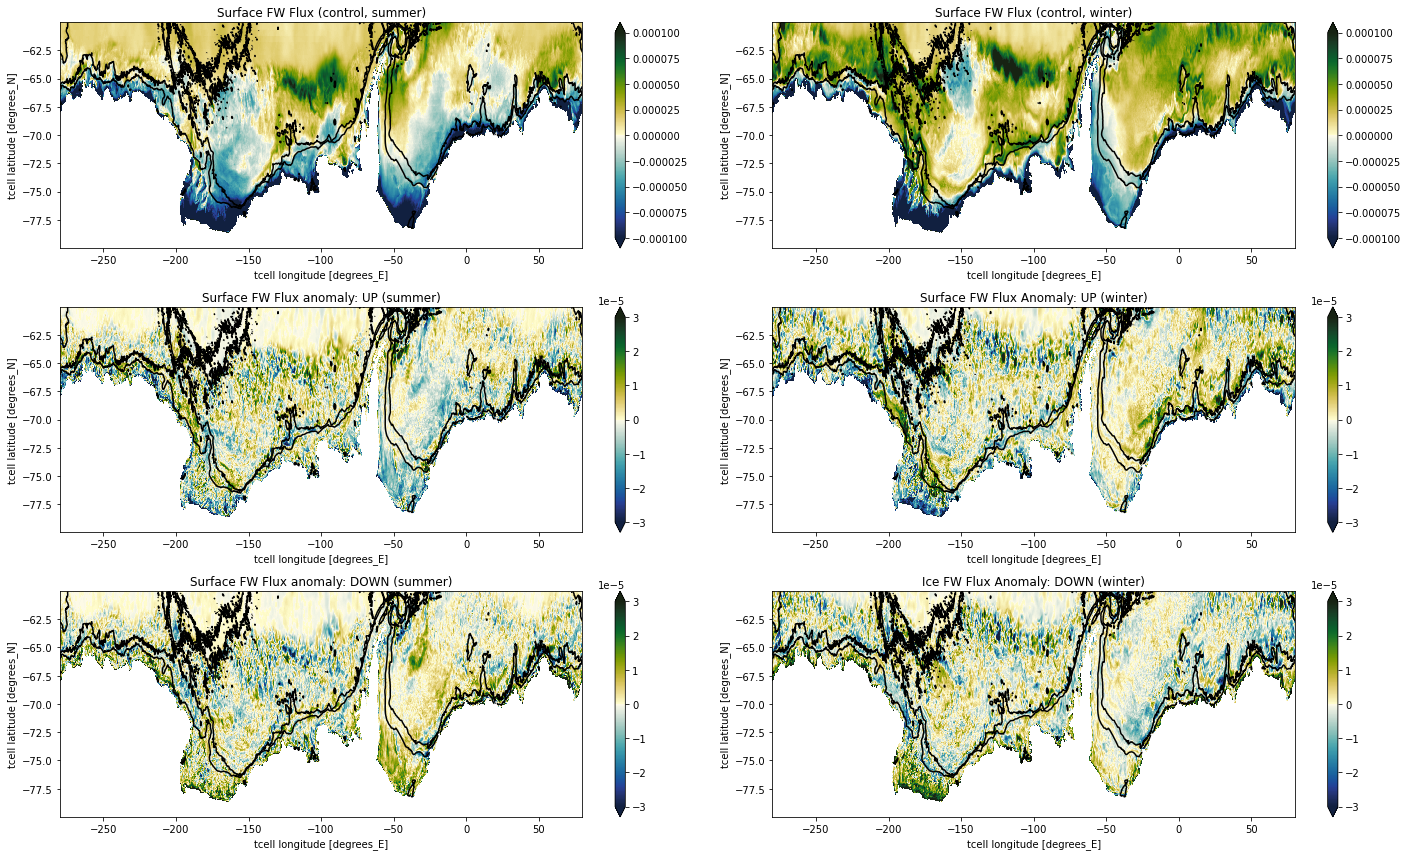

In [22]:
plt.figure(figsize=(20,12))

plt.subplot(3,2,1)
(net_sfc_fw_flux_con_summer).plot(vmin=-1e-4, vmax=1e-4, cmap=cmocean.delta)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=0.2)
plt.title('Surface FW Flux (control, summer)')

plt.subplot(3,2,2)
(net_sfc_fw_flux_con_winter).plot(vmin=-1e-4, vmax=1e-4, cmap=cmocean.delta)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=0.2)
plt.title('Surface FW Flux (control, winter)')

plt.subplot(3,2,3)
(net_sfc_fw_flux_up_summer - net_sfc_fw_flux_con_summer).plot(vmin=-3e-5, vmax=3e-5, cmap=cmocean.delta)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=0.2)
plt.title('Surface FW Flux anomaly: UP (summer)')

plt.subplot(3,2,4)
(net_sfc_fw_flux_up_winter-net_sfc_fw_flux_con_winter).plot(vmin=-3e-5, vmax=3e-5, cmap=cmocean.delta)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=0.2)
plt.title('Surface FW Flux Anomaly: UP (winter)')

plt.subplot(3,2,5)
(net_sfc_fw_flux_down_summer - net_sfc_fw_flux_con_summer).plot(vmin=-3e-5, vmax=3e-5, cmap=cmocean.delta)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=0.2)
plt.title('Surface FW Flux anomaly: DOWN (summer)')

plt.subplot(3,2,6)
(net_sfc_fw_flux_down_winter-net_sfc_fw_flux_con_winter).plot(vmin=-3e-5, vmax=3e-5, cmap=cmocean.delta)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=0.2)
plt.title('Ice FW Flux Anomaly: DOWN (winter)')

plt.tight_layout()

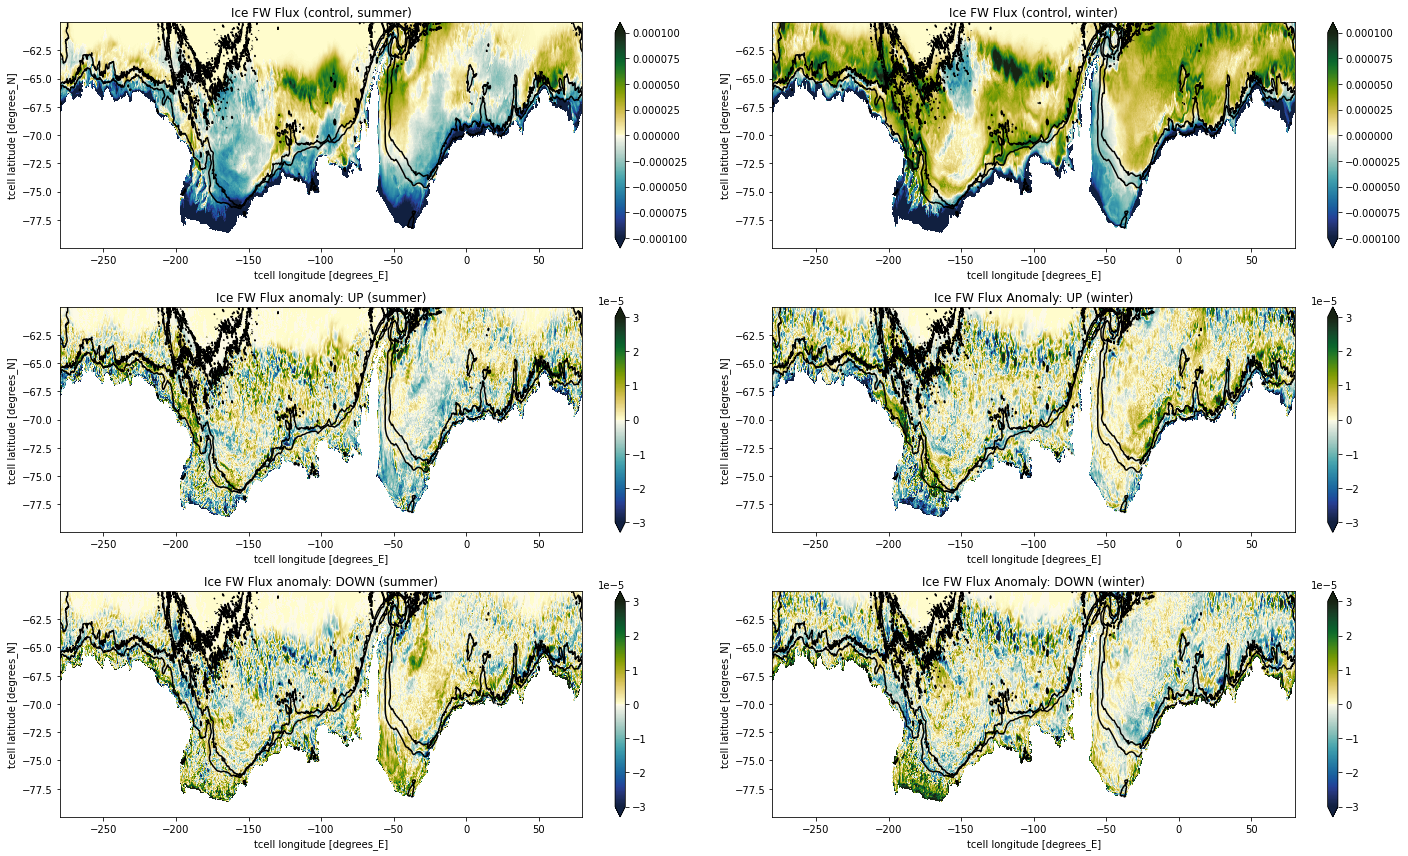

In [21]:
plt.figure(figsize=(20,12))

plt.subplot(3,2,1)
(net_ice_fw_flux_con_summer).plot(vmin=-1e-4, vmax=1e-4, cmap=cmocean.delta)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=0.2)
plt.title('Ice FW Flux (control, summer)')

plt.subplot(3,2,2)
(net_ice_fw_flux_con_winter).plot(vmin=-1e-4, vmax=1e-4, cmap=cmocean.delta)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=0.2)
plt.title('Ice FW Flux (control, winter)')

plt.subplot(3,2,3)
(net_ice_fw_flux_up_summer - net_ice_fw_flux_con_summer).plot(vmin=-3e-5, vmax=3e-5, cmap=cmocean.delta)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=0.2)
plt.title('Ice FW Flux anomaly: UP (summer)')

plt.subplot(3,2,4)
(net_ice_fw_flux_up_winter-net_ice_fw_flux_con_winter).plot(vmin=-3e-5, vmax=3e-5, cmap=cmocean.delta)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=0.2)
plt.title('Ice FW Flux Anomaly: UP (winter)')

plt.subplot(3,2,5)
(net_ice_fw_flux_down_summer - net_ice_fw_flux_con_summer).plot(vmin=-3e-5, vmax=3e-5, cmap=cmocean.delta)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=0.2)
plt.title('Ice FW Flux anomaly: DOWN (summer)')

plt.subplot(3,2,6)
(net_ice_fw_flux_down_winter-net_ice_fw_flux_con_winter).plot(vmin=-3e-5, vmax=3e-5, cmap=cmocean.delta)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidth=0.2)
plt.title('Ice FW Flux Anomaly: DOWN (winter)')

plt.tight_layout()

## Let's look at the net ice export

For now, using `melt` to infer net ice export from shelf region. This is in units of kg/m^2/s, so we will multiply by `area_t` and sum to get the total flux. We then divide by 1e9 to get and answer in Sv.

In [33]:
melt = cc.querying.getvar(control, 'melt', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
area_t = cc.querying.getvar(control, 'area_t', master_session,n=1)
ice_export_con_ts = (((melt *area_t).sel(yt_ocean=lat_slice)*shelf_mask).sum(dim={'xt_ocean','yt_ocean'})/1e9).load()

In [34]:
melt = cc.querying.getvar(easterlies_up, 'melt', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
area_t = cc.querying.getvar(easterlies_up, 'area_t', master_session,n=1)
ice_export_up_ts = (((melt *area_t).sel(yt_ocean=lat_slice)*shelf_mask).sum(dim={'xt_ocean','yt_ocean'})/1e9).load()

In [35]:
melt = cc.querying.getvar(easterlies_down, 'melt', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
area_t = cc.querying.getvar(easterlies_down, 'area_t', master_session,n=1)
ice_export_down_ts = (((melt *area_t).sel(yt_ocean=lat_slice)*shelf_mask).sum(dim={'xt_ocean','yt_ocean'})/1e9).load()

In [46]:
plt.figure(figsize=(14,8))
plt.subplot(221)
plt.plot(ice_export_con_ts.values[3:],label='control')
plt.plot(ice_export_up_ts.values,linestyle='--',label='up')
plt.plot(ice_export_down_ts.values,linestyle='--',label='down')
plt.ylabel('Melt (Sv)')
plt.title('Total Shelf Melt')
plt.subplot(222)
plt.plot(ice_export_con_ts.rolling(time=12, center=True).mean().values[3:],label='control')
plt.plot(ice_export_up_ts.rolling(time=12, center=True).mean().values,linestyle='--',label='up')
plt.plot(ice_export_down_ts.rolling(time=12, center=True).mean().values,linestyle='--',label='down')
plt.legend()
plt.title('Running Mean Shelf Melt')
plt.subplot(223)
ice_export_con_ts.groupby('time.month').mean('time').plot(label='control')
ice_export_up_ts.groupby('time.month').mean('time').plot(linestyle='--',label='up')
ice_export_down_ts.groupby('time.month').mean('time').plot(linestyle='--',label='down')
plt.legend()
plt.title('Shelf Melt Climatology')
plt.ylabel('Melt (Sv)')
plt.xlabel('Time (month)')
plt.subplot(224)
climatology = ice_export_con_ts.groupby('time.month').mean('time')
plt.plot((ice_export_con_ts.groupby('time.month') - climatology).values[3:],linestyle='--',label='control')
plt.plot((ice_export_up_ts.groupby('time.month') - climatology).values[3:],linestyle='--',label='up')
plt.plot((ice_export_down_ts.groupby('time.month') - climatology).values[3:],linestyle='--',label='down')
plt.title('Shelf Melt Anomaly (from climatology)')
plt.xlabel('Time (month)')


Text(0.5, 0, 'Time (month)')